### Histogram
Image histogram counts the number of pixels with a specific colour.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
from time import time

Let's load an example image.

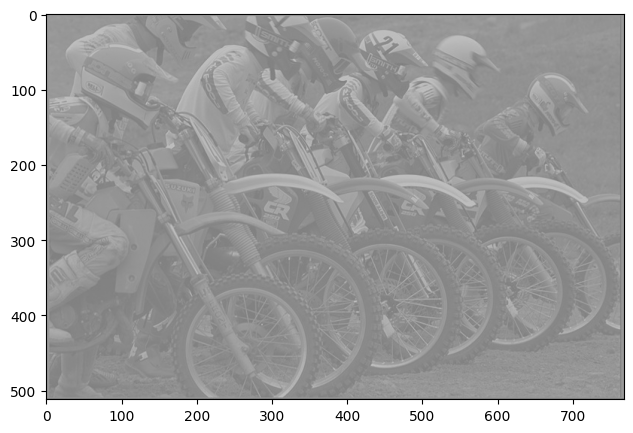

In [2]:
img = cv2.imread('data/kodim05.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)

Let's now compute the histogram by counting the number of pixels for each colour.

Elapsed time: 0.17826581001281738


(Text(0.5, 0, 'Pixel color'), Text(0, 0.5, 'Number of pixels'))

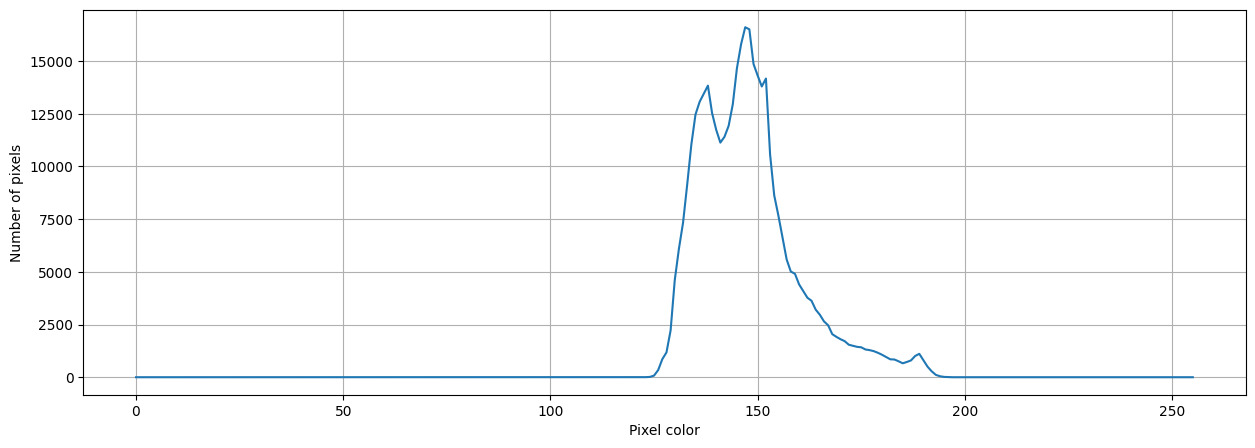

In [3]:
start = time()
rows, cols = img.shape
hist = np.zeros(256)
for r in range(rows):
    for c in range(cols):
        hist[img[r,c]] = hist[img[r,c]] + 1
print('Elapsed time:', time() - start)
plt.plot(np.arange(0, 256), hist)
plt.grid(True)
plt.xlabel('Pixel color'), plt.ylabel('Number of pixels')

### Histogram Equalization
The transformation function for histogram equalization is the cumulative distribution function (CDF). CDF is computed from image histogram.

(Text(0.5, 0, 'Pixel color'), Text(0, 0.5, 'CDF'))

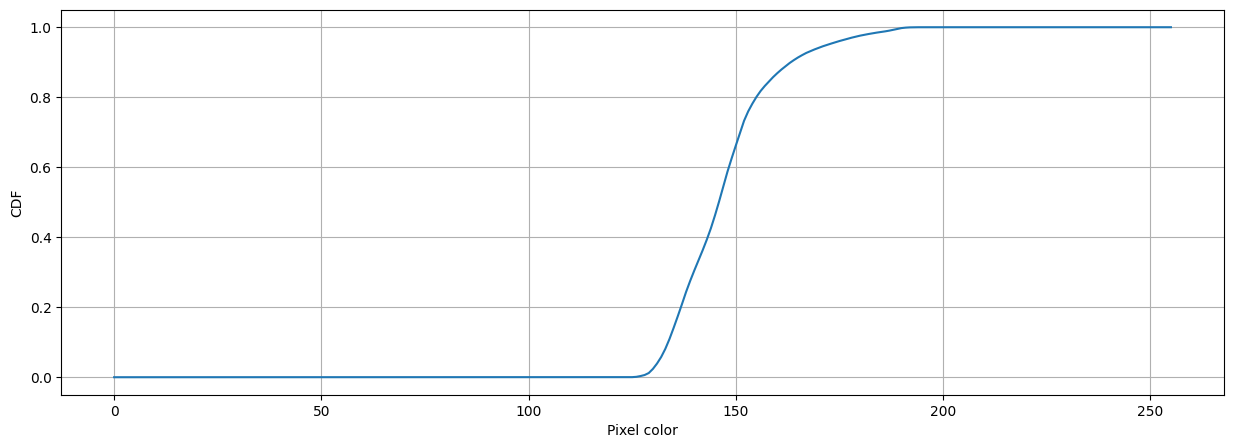

In [4]:
cdf = np.zeros(256)
for idx, h in enumerate(hist):
    cdf[idx] = np.sum(hist[0:idx+1])
cdf = cdf/np.sum(hist)
plt.plot(cdf), plt.grid(True)
plt.xlabel('Pixel color'), plt.ylabel('CDF')

(<Axes: >, <matplotlib.image.AxesImage at 0x1beabaa5310>)

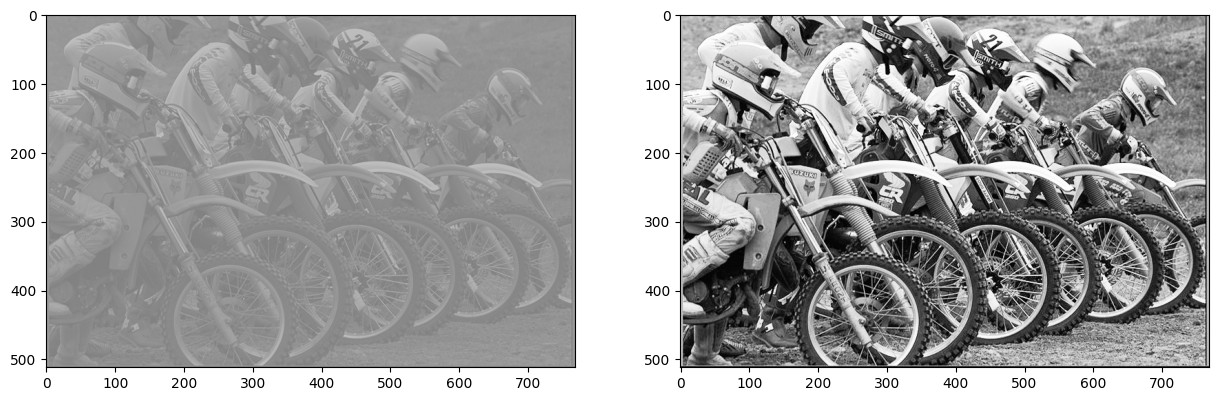

In [5]:
equalized = np.zeros((rows, cols), dtype=np.uint8)
for r in range(rows):
    for c in range(cols):
        equalized[r,c] = 255*cdf[img[r,c]]

plt.subplot(121), plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.subplot(122), plt.imshow(equalized, cmap='gray', vmin=0, vmax=255)

### Useful Functions
Histogram calculation as well as histogram equalization are available in numpy and/or OpenCV. Let's first start with histogram calculation using numpy.

Elapsed time: 0.0051727294921875


([<matplotlib.lines.Line2D at 0x1beabb4f890>], None)

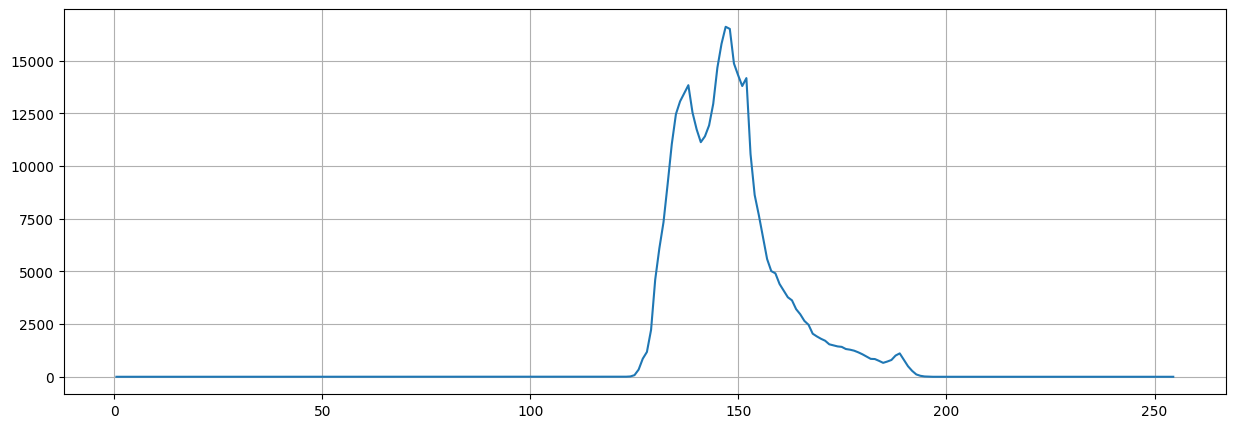

In [6]:
start = time()
hist, bins = np.histogram(img.ravel(), bins=256, range=(0,255))
print('Elapsed time:', time() - start)
plt.plot(bins[0:-1]+0.5, hist), plt.grid(True)

OpenCV includes a function for histogram equalization.

(<Axes: >, <matplotlib.image.AxesImage at 0x1beae764e10>)

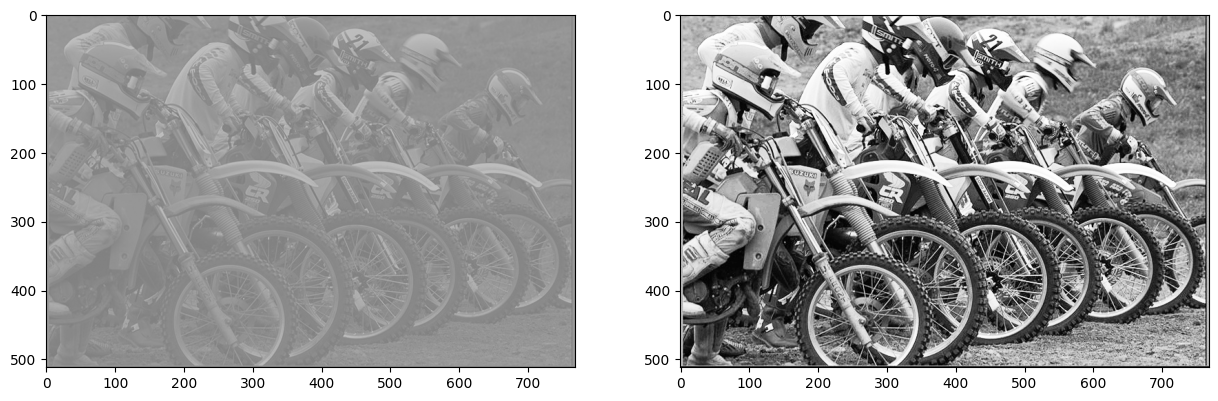

In [7]:
dst = cv2.equalizeHist(img)
plt.subplot(121), plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.subplot(122), plt.imshow(dst, cmap='gray', vmin=0, vmax=255)

### Contrast Limited Adaptive Histogram Equalization (CLAHE)
Histogram equalization assumes that an image with good contrast shall have "flat" pdf. However, this is not always true. The image below shows a dark tire and histogram equalization is too agressive.

(<Axes: >, <matplotlib.image.AxesImage at 0x1beaea56710>)

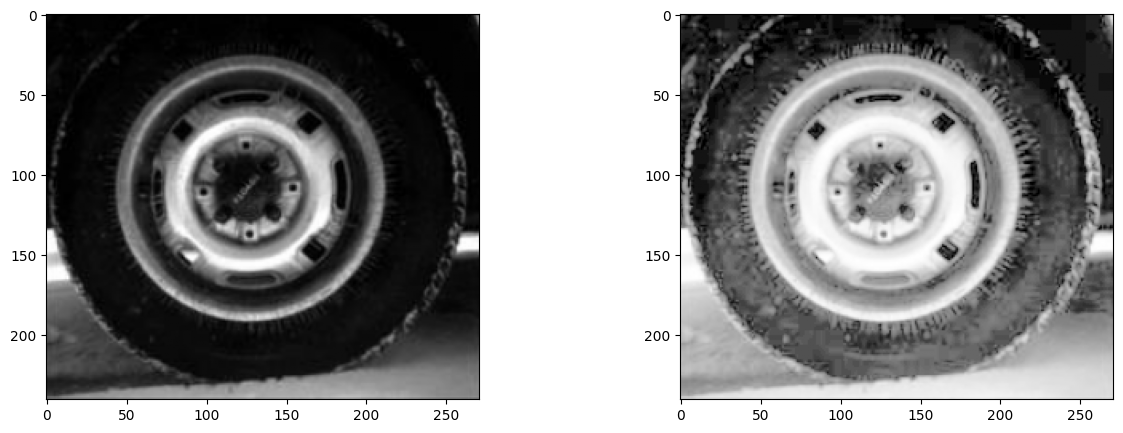

In [8]:
img = cv2.imread('data/tire.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.subplot(121), plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.subplot(122), plt.imshow(cv2.equalizeHist(img), cmap='gray', vmin=0, vmax=255)

This happens because the CDF transforms even very dark tones to quite bright levels.

(Text(0.5, 0, 'Input'), Text(0, 0.5, 'Output'))

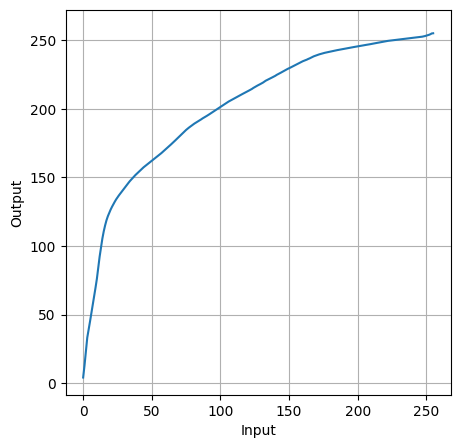

In [9]:
hist, bins = np.histogram(img.ravel(), bins=256, range=(0,255))
cdf = np.cumsum(hist/np.sum(hist))
plt.plot(255*cdf), plt.axis('square'), plt.grid(True)
plt.xlabel('Input'), plt.ylabel('Output')

Contrast limited adaptive histogram equalization clips the transformation "agressivness".

(<Axes: >, <matplotlib.image.AxesImage at 0x1beade6e210>)

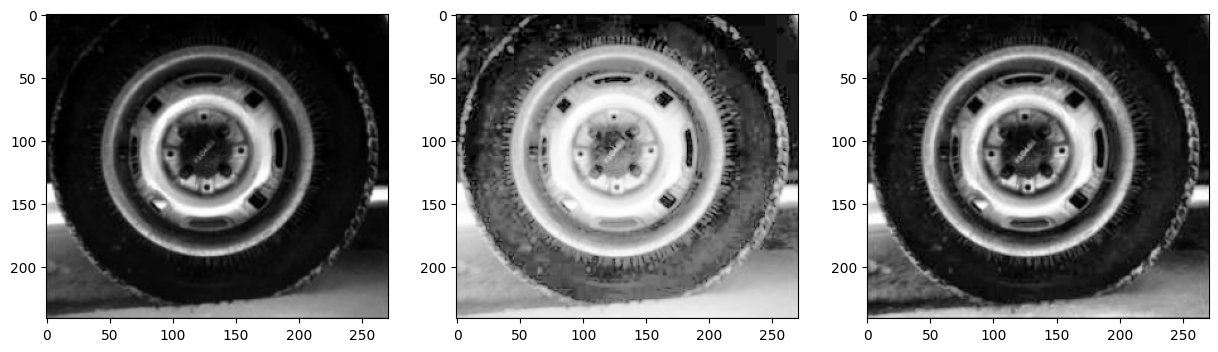

In [10]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

plt.subplot(131), plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.subplot(132), plt.imshow(cv2.equalizeHist(img), cmap='gray', vmin=0, vmax=255)
plt.subplot(133), plt.imshow(clahe.apply(img), cmap='gray', vmin=0, vmax=255)

### Histogram Equalization on Color Images

How to apply histogram equalization on color images? One option would be to equalize each of the RGB channels separately. However, this may change the color pallette of the original image and new (unnatural) color may appear. An alternative is to convert the image to the HSV color space and equalize only the luma (or value/intensity) channel. Then convert back to RGB and you are done :-)

In [11]:
from skimage import io

urls = ['https://upload.wikimedia.org/wikipedia/commons/c/c8/Common_errors_-_underexposed.jpg',
        'https://www.nikonforums.com/forums/uploads/monthly_05_2016/post-13788-0-32083700-1464045099.jpg']

images = [io.imread(url) for url in urls]

for idx, image in enumerate(images):
    plt.subplot(1,2,idx+1), plt.imshow(image), plt.axis(False)

HTTPError: HTTP Error 403: Forbidden

In [ ]:
def equalize(x, clip):
    if clip:
        return clahe.apply(x)
    else:
        return cv2.equalizeHist(x)

In [ ]:
clip = False

for idx, image in enumerate(images):
    # Equalize RGB channels
    red, green, blue = cv2.split(image)

    red = equalize(red, clip)
    blue = equalize(blue, clip)
    green = equalize(green, clip)

    plt.subplot(2,3,3*idx+1), plt.imshow(image), plt.axis(False)
    plt.subplot(2,3,3*idx+2), plt.imshow(cv2.merge([red, green, blue])), plt.axis(False)

    # Equalize luma only
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue, saturation, value = cv2.split(image_hsv)

    value = equalize(value, clip)
    out = cv2.cvtColor(cv2.merge([hue, saturation, value]), cv2.COLOR_HSV2RGB)

    plt.subplot(2,3,3*idx+3), plt.imshow(out), plt.axis(False)